## Introducción

La optimización matemática es una herramienta que se puede aplicar en cualquier ámbito para el cual se busquen soluciones acotadas por ciertas restricciones y  que cumplan un objetivo, al resolver un problema comúnmente se busca la mejor solución, esto puede significar buscar el parámetro que maximiza o minimiza un modelo planteado previamente, específicamente cuando dichos modelos son convexos (dependen de funciones convexas), se entra al campo de la optimización convexa, en el cual suele ser mucho más fácil encontrar una solución factible, es por esto que se trabaja con este tipo de optimización si tenemos un problema con ciertas características. 

A continuación vamos a plantear y resolver un problema específico de optimización convexa, en el cual el objetivo es la reconstrucción de una imagen (caracterizada por una matriz), a partir de otra imagen dada, modificando aspectos como la iluminación y el contraste de la imagen. Más concretamente, deseamos eliminar la influencia de ciertos aspectos que aparecen en una imagen al momento de su captura, y así mejorar su calidad.

Al momento de capturar una imagen diversos factores influyen en el resultado de esta, factores como nubosidad, humedad, iluminación, distribución de transmisión de la luz atmosférica,  calidad del dispositivo donde se está capturando la imagen, entre otros. Teniendo en cuenta los diferentes factores que alteran la imagen se buscará cómo recuperar la imagen que representa la escena.

## Problema Inverso

Un problema inverso se puede entender como la reconstrucción de cierto objeto, a partir de uno dado inicialmente. El elemento inicial se puede caracterizar con una matriz, y con la ayuda de ciertos parámetros preliminares relacionados al objetivo, se intenta obtener el objeto deseado, que sería una segunda matriz. Se le llama problema inverso, porque en él se trata al elemento deseado como una matriz que ha sido modificada por esos parámetros, y debido a esto se obtiene la matriz con la que iniciamos, en otras palabras,   se trata de invertir esa modificación para obtener la matriz “original”.

Daremos como ejemplo de un problema inverso el modelo utilizado para la reconstrucción de imágenes, o para desempañar imágenes, el cual se puede ver como un problema de optimización convexa. En general, los problemas inversos se pueden transformar a un problema de optimización convexa, pues la ecuación que plantea la relación entre la matriz inicial y la matriz modificada, es una ecuación lineal respecto a estas matrices, tal como veremos más adelante. Esto nos permite solucionar con más facilidad el problema dado como un problema de optimización.

## Introducción y explicación del modelo

El modelo que usaremos y con el cual se busca reconstruir una imagen que está borrosa o que tiene neblina,  está dado por:

$$I_c=J_c⊙t+a_c(1-t), \hspace{0.5cm}c=1,2,3$$

En donde  $I_c$ e  $J_c$ son matrices cuyas componentes serán los píxeles de la imagen con neblina y sin neblina respectivamente, este modelo plantea que cada pixel de la imagen con neblina es una combinación convexa entre la imagen sin neblina y una constante  $a_c$, que varía según el nivel de ruido de la imagen, esta constante depende de la iluminación, es decir, cada pixel está conformado por el pixel que queremos recuperar y la influencia que tiene la luz atmosférica sobre este, es claro que en todos los píxeles está combinación no es igual, luego aunque tenemos la restricción $0< t < 1$ , se tiene que este parámetro $t$  es distinto para cada uno de los pixeles y por tanto podemos plantear a $t$ como función de cada uno de ellos.

Ahora, teniendo en cuenta que uno de los efectos de la niebla es precisamente un decaimiento exponencial de la intensidad del color y la luz,  se toma 
$$t(x)=e^{-βd(x)}$$
Siendo $d(x)$ la distancia o profundidad de los objetos a la cámara y $\beta$ una constante que indica que tanto influye la neblina en la observación de los objetos a cierta profundidad, luego  los efectos de tener un $t$ pequeño para algún píxel en la imagen sobre la matriz $I_c$ es precisamente una pérdida del contraste y de la visibilidad de los objetos en la escena.

Teniendo en cuenta el modelo descrito, para hallar la matriz $J_c$ es necesario la previa  estimación de la constante atmosférica  $a_c$,  la cual a menudo se estima tomando la región de la imagen en donde se presenta neblina con más intensidad. El método para la estimación de acse explicará con más detalle en el código.

Adicionalmente, se puede definir una medida del contraste de la imagen, que nos diría qué tanta niebla hemos podido eliminar de la imagen inicial. Como la niebla en general homogeneiza la escena, un mayor contraste significa menos niebla. Así, el contraste se representa por medio del error cuadrático medio:

$$C_{MSE}=\sum_{p=1}^{N}\frac{(J_c(p)-J)^2}{N} = \sum_{p=1}^{N}\frac{(I_c(p)-I)^2}{t^2N},$$

donde $J_c(p)$ e $I_c(p)$ representan los valores de $J_c$ e $I_c$ en el p-ésimo pixel, $J$ e $I$ son los valores medios respectivos de cada matriz de píxeles, y $N$ es el número total de píxeles que conforman la imagen. Por cada canal de color RGB, se obtendrá una sumatoria asociada

Nota: no utilizaremos directamente esta ecuación en nuestro código, pero sirve para darnos información sobre qué necesitamos para obtener un alto contraste en nuestra imagen.


## ¿Por qué es un problema de optimización convexa?

Si observamos  la ecuación principal de nuestro modelo,

$$I_c=J_c⊙t+a_c(1-t), \hspace{0.5cm}c=1,2,3\hspace{3.5cm}(1)$$

vemos que es una combinación lineal convexa con respecto a $J_c⊙t = Q_c$, pues $0< t < 1$. Nuestra función objetivo es por lo tanto convexa respecto a $Q_c$, y lo podemos reescribir como  $Y_c= I_c -a_c1$ ,  usando  (1) en la expresión anterior, se tiene que

$$\begin{align*}
Y_c&=I_c-a_c1\\
&=(J_c⊙t+a_c(1-t))-a_c1 \\
&=Jc⊙t+a_c(1-t)-a_c1\\
&=Jc⊙t+a_c(1-t-1)\\
&=Jc⊙t-a_ct
\end{align*}$$

de donde  $Y_c= Q_c-a_ct$

Adicionalmente, solo se tendrá la restricción dada por la estimación de t(x) y a, los cuales son constantes para cada imagen, según Ic. Por lo tanto, nuestro problema es un problema convexo que se puede ver como la minimización de la norma $||I_c-(J_ct+a_c(1-t))||$, o mejor: $min||Y_c-Q_c+a_ct||$.

Ahora bien, este es un planteamiento general del problema, se puede realizar de manera más específica. Calcular una sola norma es útil cuando trabajamos en la escala de grises. Si queremos trabajar (como lo haremos nosotros) con la escala completa de color RGB, planteamos tres normas: $||Y_R-Q_R+a_Rt||$, $||Y_G-Q_G+a_Gt||$ y $||Y_B-Q_B+a_Bt||$. Por lo tanto, la función objetivo a minimizar sería:

$$min\sum_{C=R,G,B}||Y_c-Q_c+a_ct||$$

Pero, necesitamos aumentar el contraste de la imagen según los resultados deseados para la imagen sin neblina, luego al realizar dicho ejercicio  de minimización se debe sumar una función de regularización que precisamente nos ayudará a obtener mejores resultados:

$$min\sum_{C=R,G,B}||Y_c-Q_c+a_ct||+R(t, Q_c, C=R,G,B)$$ 

En este caso la función de regularización a trabajar está dada por el contraste de error cuadrático medio (MSE) explicada anteriormente, por tanto para aumentar el contraste debemos reducir los valores de t y puesto que definimos  $Y_c=Q_c-a_ct$, adicionalmente una reducción de los valores de t se da cuando los valores de $Q_c$ también se reducen, de donde deducimos que la función de regularización necesaria es:

$$R(t,Q_c,c=R,G,B)=λ_1||t||_2^2+λ_2||t||_{TV}$$

Una de las normas que se encuentran en la función de regularización es la norma de variación total  $||\cdot||_{TV}$, por definición la función de variación total de una función diferencial en un intervalo cerrado de los reales $[a,b]$, está dada por $V_b^a(f)=\int_b^a|f'(x)|dx$,  luego al minimizar la norma de variación total de t se obtiene que $||t||_{TV}$ es una constante, y de igual forma $||t||_2^2$ es una constante.

La razón para añadir una función de regularización, es que esta nos da mayor flexibilidad a la hora de obtener la imagen final restaurada, por lo que añadimos las constantes$λ_1$ y $λ_2$, que se tomarán según los resultados que se quieran para la imagen deseada y que así permitirán una mayor o menor variación para $t$.

## Aplicación del problema inverso

En principio, la resolución del problema inverso para la reconstrucción de imágenes, es sólo un caso particular de una gran cantidad de problemas que se pueden plantear como una combinación convexa similar a la que se muestra arriba como modelo. Gracias a qué, como se ha dicho, una imagen digital se puede caracterizar mediante una matriz para los fines propuestos, podemos usar ese modelo de combinación convexa para resolver este problema.

Dentro del dominio de los problemas de reconstrucción de imágenes, hay igualmente gran diversidad de aplicaciones particulares. Se puede utilizar para mejorar la calidad de una imagen borrosa; para diferenciar los píxeles de una imagen, y en general para modificar ciertos detalles globales de la imagen y así eliminar posibles imperfecciones.

Específicamente, nuestro contexto será la implementación de la reconstrucción de imágenes como una herramienta para los automóviles autónomos. Aunque nuestra intención no es trabajar directamente con ese campo, lo que queremos es sugerir la utilidad de cierto modelo para que sea aplicado, por ejemplo, en ese contexto. En cualquier caso, no se trataría de una aplicación por completo extraña a lo que nos proponemos en este proyecto, porque parte del proceso que realizaremos tiene cierta continuidad con lo que es relevante para el manejo de un automóvil autónomo. Piénsese por ejemplo en la importancia de determinar la distancia a ciertos objetos cercanos, desde el automóvil.

## Importancia de la reconstrucción de imágenes

Es importante resolver el problema de reconstrucción de imágenes ya que muchas veces al capturar una imagen, esta se puede dañar por el movimiento, bien sea de quien capturó el momento, o por el movimiento en el ambiente. La imagen también se puede ver afectada por la calidad del dispositivo, factores ambientales como nubosidad, humedad, incidencia de la luz atmosférica, etc, estos factores desvanecen los colores y reducen el contraste de los objetos capturados. Al quitar todo lo que deteriora la imagen y obteniendo como salida del problema una imagen clara y nítida, se puede obtener información de suma importancia. En muchas áreas es importante tener una imagen clara para obtener información; como sucede en la medicina, astronomía, meteorología, etc. Es por eso que solucionar este problema es útil y ayudaría a diferentes aplicaciones en la actualidad.

## Librerías a usar

Vamos a usar las siguientes librerías de Python:
  
$\cdot \textbf{ cv2}$: También conocida como OpenCV es una librería para visión artificial de código abierto. 

$\cdot \textbf{ copy}$: Este módulo estándar permite crear copias de distintos objetos.

$\cdot \textbf{ cvxpy}$: Es un lenguaje de modelado integrado en Python de código abierto para problemas de optimización convexa.

$\cdot \textbf{ numpy}$: Esta librería es especializada en el cálculo numérico y el análisis de datos

# NUESTRO CÓDIGO

### Instalación de las librerías que usaremos

In [1]:
# !pip install cvxpy
# !pip install numpy
# !pip install opencv-python

### Funciones para calcular los parámetros que usaremos en nuestro modelo

In [2]:
import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt

# Calculamos A para encontrar la luz del aire

def Airlight(HazeImg, windowSize):
    A = []
    for ch in range(len(HazeImg.shape)):
      kernel = np.ones((windowSize, windowSize), np.uint8)
      minImg = cv2.erode(HazeImg[:, :, ch], kernel)
      A.append(int(minImg.max()))
    return(A)

In [15]:
# Calculamos la función de transmisión para cada pixel. La matriz que retornamos 
# es del mismo tamaño de la imagen de entrada y cada elemento tendra un valor entre 0 y 1

def Transmission(HazeImg, A, C0, C1):
    t_b = np.maximum((A[0] - HazeImg[:, :, 0].astype(np.float)) / (A[0] - C0),
                      (HazeImg[:, :, 0].astype(np.float) - A[0]) / (C1 - A[0]))
    t_g = np.maximum((A[1] - HazeImg[:, :, 1].astype(np.float)) / (A[1] - C0),
                      (HazeImg[:, :, 1].astype(np.float) - A[1]) / (C1 - A[1]))
    t_r = np.maximum((A[2] - HazeImg[:, :, 2].astype(np.float)) / (A[2] - C0),
                      (HazeImg[:, :, 2].astype(np.float) - A[2]) / (C1 - A[2]))
    MaxVal = np.maximum(t_b, t_g, t_r)
    transmission = np.minimum(MaxVal, 1)
    return(transmission)

### Construcción del modelo usando CVXPY

In [16]:
import cvxpy as cp
from cvxpy.atoms.norm1 import norm1
from cvxpy.atoms.pnorm import pnorm

def removeHaze(HazeImg,Transmission, A, delta, Regularize = False):
    epsilon = 0.0001
    Transmission = pow(np.maximum(abs(Transmission), epsilon), delta)
    HazeCorrectedImage = copy.deepcopy(HazeImg)
    for ch in range(len(HazeImg.shape)):
        # Definimos los parámetros para construir el modelo en CVXPY
        I_c = cp.Parameter(HazeImg[:, :, ch].shape)
        I_c.value = HazeImg[:, :, ch]        
        t_c = cp.Parameter(Transmission.shape)
        t_c.value = Transmission
        a_c = cp.Parameter()
        a_c.value = A[ch]

        # Definimos la variable a optimizar, que en este caso es la imagen sin niebla que queremos recuperar
        J_c = cp.Variable(HazeCorrectedImage[:, :, ch].shape)
        J_c.value = HazeCorrectedImage[:, :, ch]

        # Si el canal que se optimiza es el azul se escoge un lamba_2 ligeramente más grande para obtener mejores resultados
        if ch==2:            
            lambda_1 = -0.01
            lambda_2 = 0.0015
        else:
            lambda_1 = -0.01
            lambda_2 = 0.001

        # Definimos la expresión que vamos a minimizar        
        if Regularize:
          expression = I_c-(cp.multiply(J_c,t_c) + a_c*(1-t_c))+(lambda_1*(cp.norm(t_c,p=2).value))+lambda_2*cp.tv(t_c).value
        else:
          expression = I_c-(cp.multiply(J_c,t_c) + a_c*(1-t_c))        
        objective = cp.Minimize(cp.sum_squares(expression))

        # Definimos las restricciones, que en este caso es que cada pixel tenga un valor entre 0 y 255
        constraints = [0 <= J_c, J_c <= 255]
        prob = cp.Problem(objective, constraints)        
        prob.solve()
        print("Optimizando")
        temp=J_c.value
        temp = np.maximum(np.minimum(temp, 255), 0)
        HazeCorrectedImage[:, :, ch] = temp    
    return(HazeCorrectedImage)  

## Ejemplos de resultados

Ejecutamos el siguiente código para ver un ejemplo de como funciona el problema de reconstrucción de imágenes. Se presenta una imagen de la ciudad de Bogotá en un día nublado y lluvioso.

Tamaño de la imagen: (716, 1000, 3)
Optimizando
Optimizando
Optimizando

Imagen original


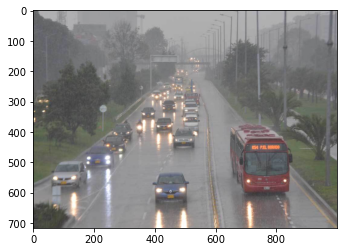

Imagen reconstruida


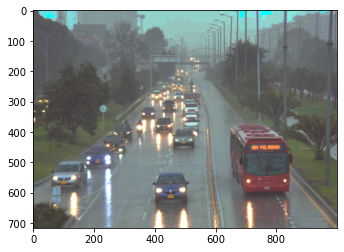

In [17]:
HazeImg = cv2.imread('transmi.jpg')	
print("Tamaño de la imagen:", HazeImg.shape)

# Estimamos la luz del aire. 
# Podemos cambiar el tamaño del kernel que usamos para la erosión de la imagen
windowSize_erode = 25
A = Airlight(HazeImg, windowSize_erode)

# Cotas para el cálculo que la transmisión de luz. Se utilizan las propuestas en el paper
C0=20
C1=300
t = Transmission(HazeImg,A,C0,C1)

# El último parámetro es para definir si se regulariza la imagen o no
HazeCorrectedImg = removeHaze(HazeImg, t, A, 0.4, True)

rgb_img_original = cv2.cvtColor(HazeImg, cv2.COLOR_BGR2RGB)		# this converts it into RGB
rgb_img_dehazed = cv2.cvtColor(HazeCorrectedImg, cv2.COLOR_BGR2RGB)		# this converts it into RGB

print("")
print("Imagen original")
plt.imshow(rgb_img_original)
plt.show()
print("Imagen reconstruida")
plt.imshow(rgb_img_dehazed)
plt.show()


# Código para guardar las imágenes localmente

# cv2.imwrite('HazeImg.png',HazeImg)
# cv2.imwrite('HazeCorrectedImg.png',HazeCorrectedImg)

# Conclusiones

Gracias a que el problema inverso se pudo plantear como un problema de optimización convexa, fue posible utilizar la librería de cvx para Python, con lo que fue mucho más sencillo resolver para obtener la imagen deseada. En general siempre es recomendable plantear problemas numéricos en la forma de una minimización o una maximización para simplificar el proceso.

Respecto a la formulación específica del problema inverso que utilizamos, podemos hacer algunas observaciones respecto a los parámetros. Estos dependen considerablemente de la fotografía. Por ejemplo, la distancia, que en el código hemos llamado (x) determina en gran medida la distribución de la luz, por lo que es recomendable modificarlo según las circunstancias de las figuras. 

Asimismo, para la función de regularización, puede haber algunas imágenes que no necesiten de ésta para una mejora, mientras que otras pueden mejorar mucho, según los deseos del usuario. Asignar los parámetros de esta función es clave para manipular la luz, los colores y el contraste de la imagen. Así lo hemos hecho nosotros en ciertos casos, y en las muestras se puede observar los buenos resultados del modelo. Así mismo, se puede variar el uso de las normas si se quiere priorizar algún resultado sobre otro.

También es importante manejar por separado cada registro de color, porque de lo contrario es posible que se anteponga un color sobre el otro, así que se puede variar por separado los parámetros del rojo, el azul y el verde.

Según algunas muestras aplicadas a nuestro modelo, vimos que podía ser útil para aplicaciones en donde se necesite de contraste alto para diferenciar objetos en fotografías, como en el caso de la conducción de automóviles autónomos. En algunos casos, como cuando hay gran variación en las distancias, los colores pueden no ser los adecuados, pero se incrementa el realce del contorno de las figuras, incluso de aquellos que son lejanas.

# Referencias

https://github.com/Utkarsh-Deshmukh/Single-Image-Dehazing-Python/blob/master/src/removeHaze.py

https://www.cv-foundation.org/openaccess/content_iccv_2013/papers/Meng_Efficient_Image_Dehazing_2013_ICCV_paper.pdf

https://www.researchgate.net/publication/307516271_Convex_optimization_for_fast_image_dehazing 

https://www.researchgate.net/publication/221110862_Fast_Visibility_Restoration_from_a_Single_Color_or_Gray_Level_Image

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8323906/